In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("Sales_Data_Record.xlsx")

### Most Frequent sold Product

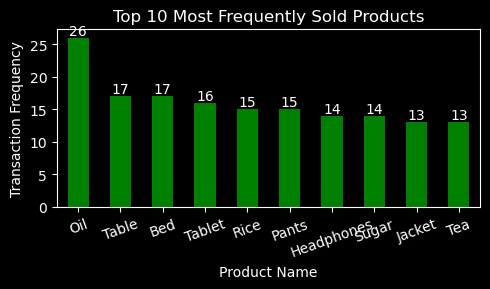

In [13]:

top_5_products = data['Sold Product Name'].value_counts().head(10)
plt.figure(figsize=(5, 3))
ax = top_5_products.plot(kind='bar', color='Green')
plt.style.use('dark_background')
plt.title('Top 10 Most Frequently Sold Products')
plt.xlabel('Product Name')
plt.ylabel('Transaction Frequency')
plt.xticks(rotation=20)

for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()


### Total Sales Amount by Membership Status and Payment Method

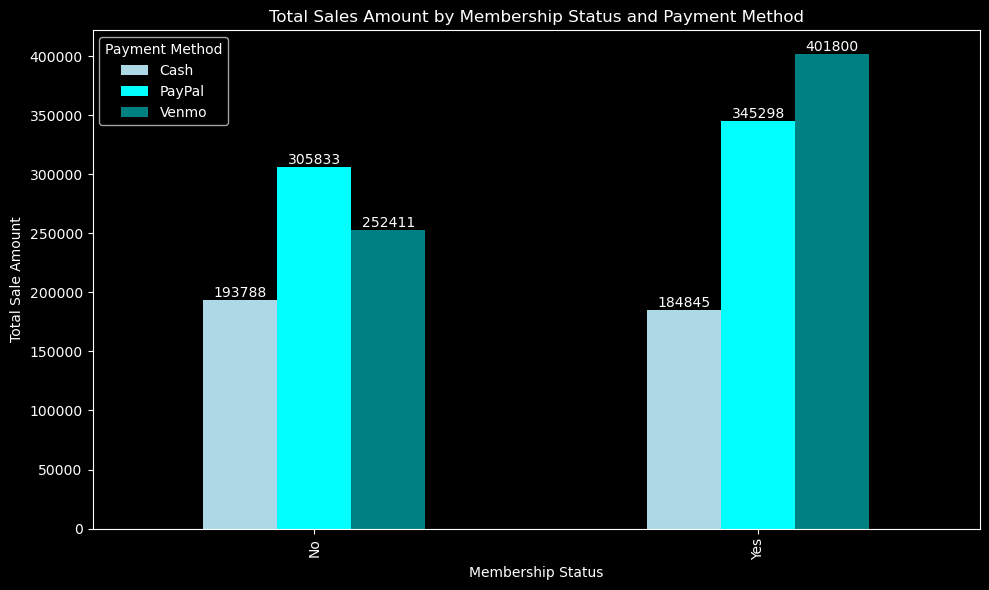

In [14]:

grouped_data = data.groupby(['Membership', 'Payment Method'])['Total Sale Amount'].sum().unstack()

grouped_data.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'cyan', 'teal'])

plt.title('Total Sales Amount by Membership Status and Payment Method')
plt.xlabel('Membership Status')
plt.ylabel('Total Sale Amount')

for container in plt.gca().containers:
    plt.bar_label(container)

plt.tight_layout()
plt.show()


### Sales Heatmap by Day of the Week and Month

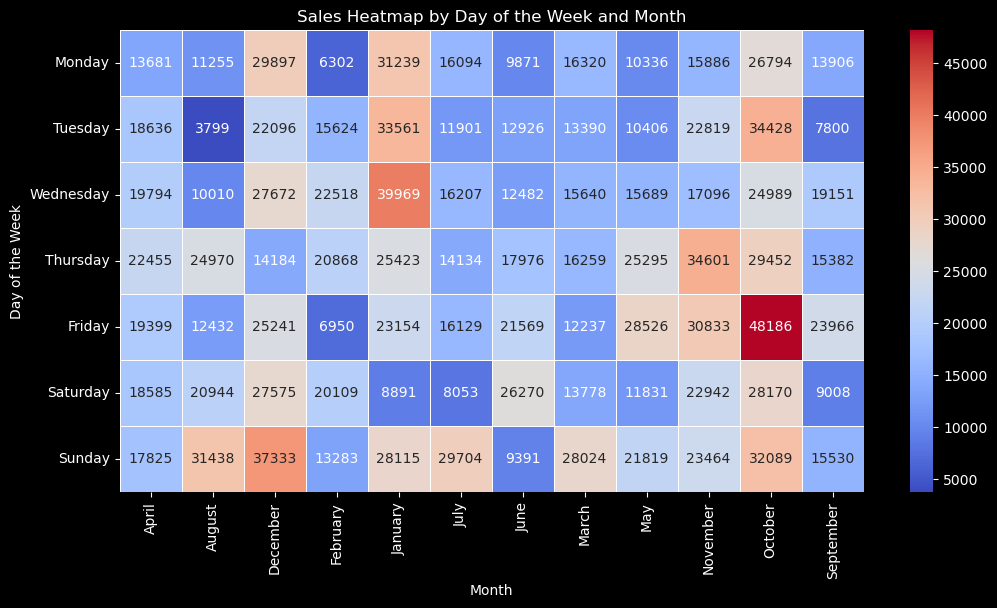

In [15]:
data['Date'] = pd.to_datetime(data['Date'])

data['Day of Week'] = data['Date'].dt.day_name()  
data['Month'] = data['Date'].dt.month_name()  

sales_pivot = data.pivot_table(index='Day of Week', columns='Month', values='Total Sale Amount', aggfunc='sum')

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_pivot = sales_pivot.reindex(order)

plt.figure(figsize=(12, 6))
sns.heatmap(sales_pivot, cmap='coolwarm', annot=True, fmt=".0f", linewidths=0.5)
plt.title('Sales Heatmap by Day of the Week and Month')
plt.xlabel('Month')
plt.ylabel('Day of the Week')
plt.show()


### Total Sales Trend by Month

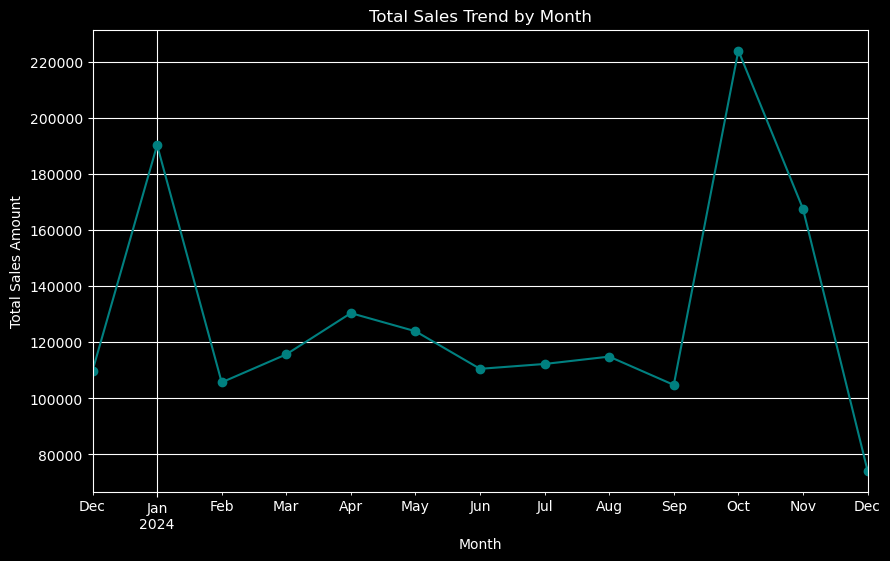

In [16]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year-Month'] = data['Date'].dt.to_period('M')
monthly_sales = data.groupby('Year-Month')['Total Sale Amount'].sum()

plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line', marker='o', color='teal')
plt.title('Total Sales Trend by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.grid(True)
plt.show()


### Monthly Profit Margin for Each Product Category

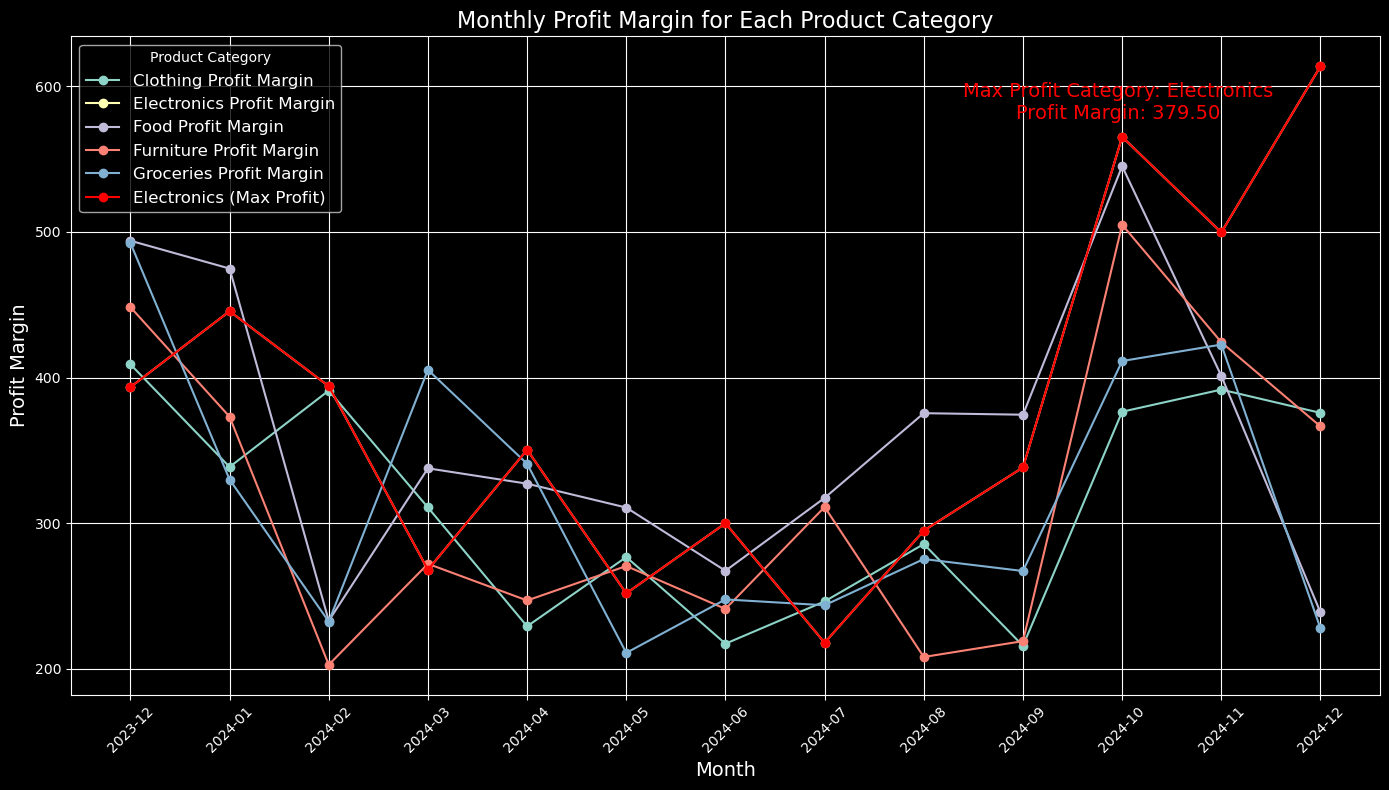

In [17]:
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month  
data['Year-Month'] = data['Date'].dt.to_period('M')  

monthly_profit_margin = data.groupby(['Year-Month', 'Product Category'])['Profit Margin'].mean().reset_index()

avg_profit_margin_by_category = monthly_profit_margin.groupby('Product Category')['Profit Margin'].mean()
max_profit_category = avg_profit_margin_by_category.idxmax()  # Product category with the max profit margin
max_profit_value = avg_profit_margin_by_category.max()  # Max profit margin value

# Plotting the profit margin by Product Category for each Month
plt.figure(figsize=(14, 8))

for category in monthly_profit_margin['Product Category'].unique():
    category_data = monthly_profit_margin[monthly_profit_margin['Product Category'] == category]
    plt.plot(category_data['Year-Month'].astype(str), category_data['Profit Margin'], marker='o', label=f'{category} Profit Margin')

plt.plot(monthly_profit_margin[monthly_profit_margin['Product Category'] == max_profit_category]['Year-Month'].astype(str),
         monthly_profit_margin[monthly_profit_margin['Product Category'] == max_profit_category]['Profit Margin'], 
         marker='o', color='red', label=f'{max_profit_category} (Max Profit)')

plt.title('Monthly Profit Margin for Each Product Category', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Profit Margin', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Product Category", fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.text(0.8, 0.9, f"Max Profit Category: {max_profit_category}\nProfit Margin: {max_profit_value:.2f}", 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=14, color='red')

plt.show()


### Monthly Sales Trend and Forecast for Next Year

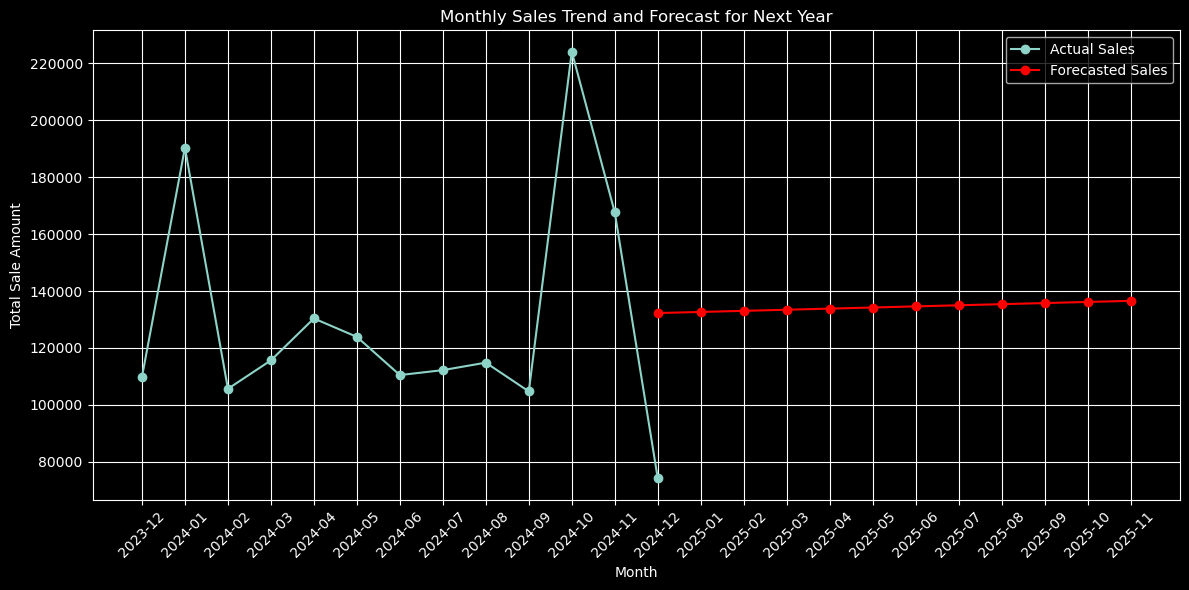

In [21]:
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5,
                 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
                 'November': 11, 'December': 12}


data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month  
data['Year-Month'] = data['Date'].dt.to_period('M')  

monthly_sales = data.groupby('Year-Month')['Total Sale Amount'].sum().reset_index()

# Add numeric month for regression
monthly_sales['Numeric_Month'] = np.arange(len(monthly_sales))

# Define features (X) and target (y)
X = monthly_sales[['Numeric_Month']]
y = monthly_sales['Total Sale Amount']

# Train Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict future sales for the next 12 months
future_months = np.arange(X['Numeric_Month'].max() + 1, X['Numeric_Month'].max() + 13).reshape(-1, 1)
future_sales = model.predict(future_months)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start=monthly_sales['Year-Month'].max().to_timestamp(), periods=12, freq='M')
predicted_data = pd.DataFrame({'Date': future_dates, 'Predicted Sales': future_sales})

# Plot actual and forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Year-Month'].astype(str), monthly_sales['Total Sale Amount'], marker='o', label='Actual Sales')
plt.plot(predicted_data['Date'].dt.to_period('M').astype(str), predicted_data['Predicted Sales'], marker='o', label='Forecasted Sales', color='red')
plt.title('Monthly Sales Trend and Forecast for Next Year')
plt.xlabel('Month')
plt.ylabel('Total Sale Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Monthly Sales Trend and Forecast for Each Product Category

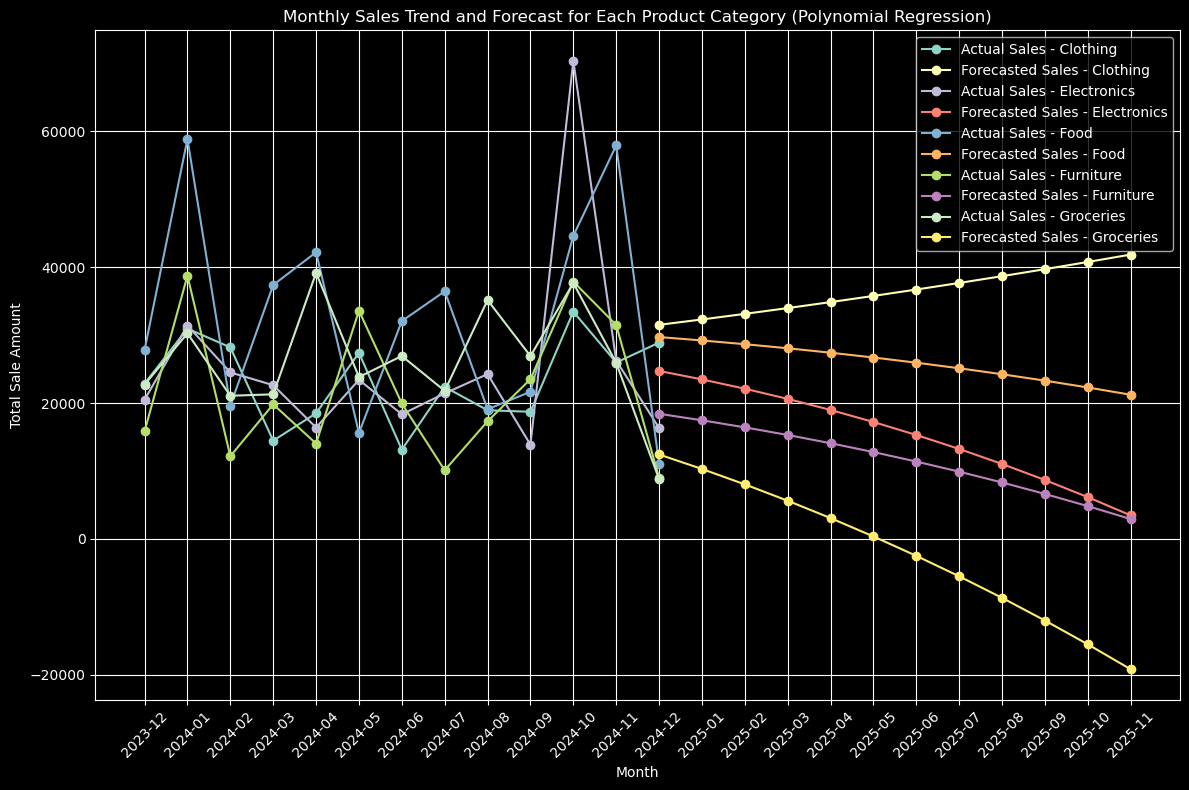

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Ensure Date is in datetime format
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month  # Extract numeric month
data['Year-Month'] = data['Date'].dt.to_period('M')  # Extract year-month as period

# Aggregate total sales by Month and Product Category
monthly_sales_by_category = data.groupby(['Year-Month', 'Product Category'])['Total Sale Amount'].sum().reset_index()

# Create a column for numeric month for regression
monthly_sales_by_category['Numeric_Month'] = np.arange(len(monthly_sales_by_category))

# Polynomial Regression for each Product Category
product_categories = monthly_sales_by_category['Product Category'].unique()

plt.figure(figsize=(12, 8))

for category in product_categories:
    category_data = monthly_sales_by_category[monthly_sales_by_category['Product Category'] == category]
    
    # Define features (X) and target (y)
    X = category_data[['Numeric_Month']]
    y = category_data['Total Sale Amount']
    
    # Polynomial Regression with a degree of 3 (can adjust degree based on trend)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    
    # Train the Polynomial Regression model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predict future sales for the next 12 months
    future_months = np.arange(X['Numeric_Month'].max() + 1, X['Numeric_Month'].max() + 13).reshape(-1, 1)
    future_months_poly = poly.transform(future_months)
    future_sales = model.predict(future_months_poly)
    
    # Create a DataFrame for future predictions
    future_dates = pd.date_range(start=category_data['Year-Month'].max().to_timestamp(), periods=12, freq='M')
    predicted_data = pd.DataFrame({'Date': future_dates, 'Predicted Sales': future_sales, 'Product Category': category})
    
    # Plot actual and forecasted sales
    plt.plot(category_data['Year-Month'].astype(str), category_data['Total Sale Amount'], marker='o', label=f'Actual Sales - {category}')
    plt.plot(predicted_data['Date'].dt.to_period('M').astype(str), predicted_data['Predicted Sales'], marker='o', label=f'Forecasted Sales - {category}', linestyle='-')

plt.title('Monthly Sales Trend and Forecast for Each Product Category (Polynomial Regression)')
plt.xlabel('Month')
plt.ylabel('Total Sale Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Here is the full update of my revanalyica python project. i used Tkinter to take input in my dataset ( in tkinter i used some method) 
those method  are:
1. store data,
2. search from dataset,
3. i can also Edit data by searching data ( i used transaction id to find the specific data of customer) 
4. i used submit function.
5. after submiting the data. data will store in dataaset .
6. *** most important: i used most frquent item tab : where the most sold item will shown.
7. 6. after taking the data i analysed them Using ( pandas, numpy, matplotlib, seaborn)
    here i did analysis of :
    a) Most Frequent sold Product
    b) Total Sales Amount by Membership Status and Payment Method
    c) Sales Heatmap by Day of the Week and Month
    d) Total Sales Trend by Month
    e) Monthly Profit Margin for Each Product Category
    f) Monthly Sales Trend and Forecast for Next Year
    g) Monthly Sales Trend and Forecast for Each Product Category

